# LSTM

## Caricamento del dataframe

In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from torch.utils.tensorboard import SummaryWriter

import os
import shutil
import glob

main_folder = "../data"

folder = "./runs/LSTM"

try:
    #shutil.rmtree(folder + "/Acc_train_val_train")
    #shutil.rmtree(folder + "/Acc_train_val_val")
    #shutil.rmtree(folder + "/Loss_train_val_train")
    #shutil.rmtree(folder + "/Loss_train_val_val")
    #os.rmdir(folder + "/Acc_train_val_train")
    #os.rmdir(folder + "/Acc_train_val_val")
    #os.rmdir(folder + "/Loss_train_val_train")
    #os.rmdir(folder + "/Loss_train_val_val")
    #shutil.rmtree(folder)
    #os.rmdir(folder)
    shutil.rmtree(folder, ignore_errors=True)
except:
    pass

try:
    os.mkdir(folder)
except:
    pass

writer = SummaryWriter(folder)

## Train - Validation - Test

In [2]:
class2idx = {
    "No_action": 0,
    "Prendi": 1,
    "Rilascia": 2,
    "Premi": 3
}

idx2class = {v: k for k, v in class2idx.items()}

In [3]:
def join_csv(folder_set, filename):
    csv:list = []

    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)

    columns:bool = True
    with open(filename, "w") as f:
        for fcsv in csv:
            with open(fcsv, "r") as fc:
                if columns:
                    f.writelines(fc.readlines())
                    columns = False
                fc.readline()
                f.writelines(fc.readlines())

In [4]:
def create_set(folder_set, filename) -> list:
    csv:list = []
    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)
    columns:bool = True
    colname = []
    data = []
    target = []
    for fcsv in csv:
        data_video = []
        target_video = []
        with open(fcsv, "r") as fc:
            if columns:
                colname = [(name) for name in fc.readline().split(",")]
                colname[-1] = colname[-1][:-1]
                columns = False
            else:
                fc.readline()
            for row in fc.readlines():
              split_row = row.split(",")
              data_video.append(split_row[:-1])
              target_video.append(class2idx[split_row[-1][:-1]])
        data.append(np.array(data_video).astype(float))
        target.append(np.array(target_video).astype(int))
    return (np.array(data, dtype=object), np.array(target, dtype=object), colname)

In [5]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

train_array, train_label_array, colname = create_set(folder_set[0][0], folder_set[0][1])
test_array, test_label_array, colname = create_set(folder_set[1][0], folder_set[1][1])
val_array, val_label_array, colname = create_set(folder_set[2][0], folder_set[2][1])
#print(train_array.shape, train_label_array.shape, test_array.shape, test_label_array.shape, val_array.shape, val_label_array.shape, colname)
for elem, label in zip(train_array, train_label_array):
  print(elem.shape, label.shape)
  print(type(elem), type(label))

(1031, 156) (1031,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2367, 156) (2367,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2193, 156) (2193,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1245, 156) (1245,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2247, 156) (2247,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(563, 156) (563,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3791, 156) (3791,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(971, 156) (971,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1361, 156) (1361,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1188, 156) (1188,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(819, 156) (819,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1164, 156) (1164,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1732, 156) (1732,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(486, 156) (486,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1516, 156) (1516,)
<class 'numpy.ndarray'> <class 'nump

In [6]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

for f_set, filename in folder_set:
    join_csv(f_set, filename)
    
train = pd.read_csv(main_folder + "/train.csv")
test = pd.read_csv(main_folder + "/test.csv")
val = pd.read_csv(main_folder + "/val.csv")

train['TARGET'].replace(class2idx, inplace=True)
test['TARGET'].replace(class2idx, inplace=True)
val['TARGET'].replace(class2idx, inplace=True)

In [7]:
train.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
test.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
val.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
print(train.shape[0], test.shape[0], val.shape[0])

54886 16126 10453


In [11]:
def create_dataset(dataset, target, window_size = 2):
    dataX, dataY = [], []
    for i in range(len(dataset) - window_size):
        dataX.append(dataset[i:(i + window_size)])
        dataY.append(target[i:(i + window_size + 1)].values[0])
    return np.array(dataX), np.array(dataY)

Si separano le colonne delle features dall'etichetta.

In [12]:
train_label = train["TARGET"]
test_label = test["TARGET"]
val_label = val["TARGET"]

del train["TARGET"]
del test["TARGET"]
del val["TARGET"]

## Visualizzazione della distribuzione delle classi in Train, Val e Test

In [13]:
def get_class_distribution(obj):
    count_dict = {
        "No_action": 0,
        "Prendi": 0,
        "Rilascia": 0,
        "Premi": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['No_action'] += 1
        elif i == 1: 
            count_dict['Prendi'] += 1
        elif i == 2: 
            count_dict['Rilascia'] += 1
        elif i == 3: 
            count_dict['Premi'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

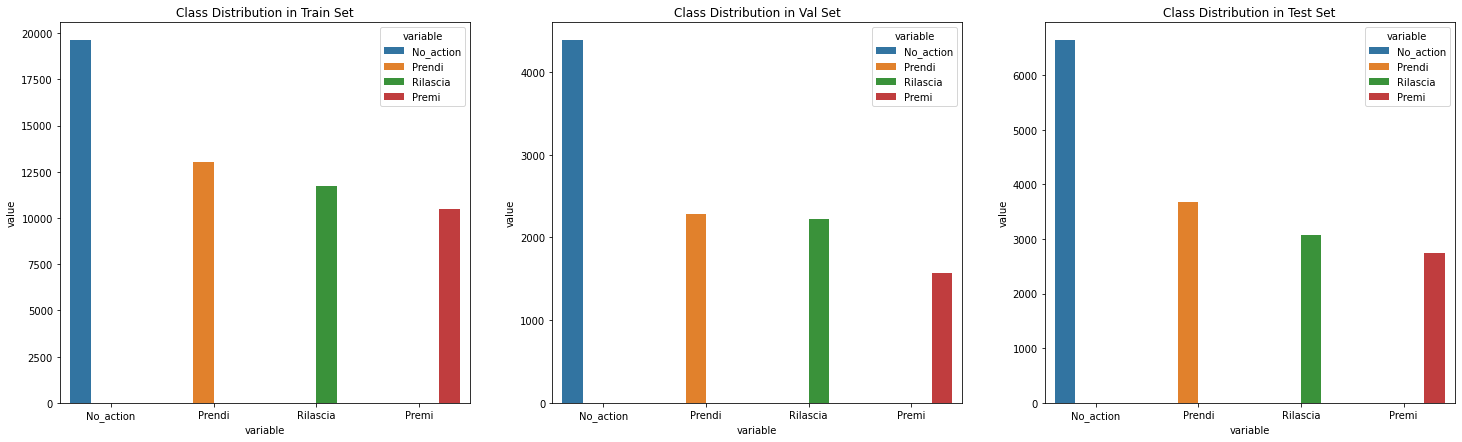

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [16]:
window_size = 1

In [17]:
train_X, train_Y = create_dataset(train, train_label, window_size)
train_dataset_w = ClassifierDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long())

test_X, test_Y = create_dataset(test, test_label, window_size)
test_dataset_w = ClassifierDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).long())

val_X, val_Y = create_dataset(val, val_label, window_size)
val_dataset_w = ClassifierDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_Y).long())


train_dataset = [(ClassifierDataset(torch.from_numpy(array).float(), torch.from_numpy(label).long())) for array, label in zip(train_array, train_label_array)]

test_dataset = [(ClassifierDataset(torch.from_numpy(array).float(), torch.from_numpy(label).long())) for array, label in zip(test_array, test_label_array)]

val_dataset = [(ClassifierDataset(torch.from_numpy(array).float(), torch.from_numpy(label).long())) for array, label in zip(val_array, val_label_array)]

In [18]:
print(train_dataset[0].X_data.shape)
print(train_dataset[0].y_data.shape)

torch.Size([1031, 156])
torch.Size([1031])


## Weighted Sampling

Poiché c'è uno squilibrio di classe, utilizziamo la suddivisione stratificata per creare i nostri set di train, convalida e test.

In [19]:
target_list = []

for _, t in train_dataset_w:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

Quindi, otteniamo il conteggio di tutte le classi nel nostro set di allenamento.  Usiamo il reciproco di ogni conteggio per ottenere il suo peso.  Ora che abbiamo calcolato i pesi per ogni classe, possiamo procedere.

In [20]:
class_count = [i for i in get_class_distribution(train_label).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

print(class_weights)

tensor([5.1000e-05, 7.6664e-05, 8.5157e-05, 9.5320e-05])


WeightedRandomSampler prevede un peso per ogni campione.  Lo usiamo come segue.

In [21]:
class_weights_all = class_weights[target_list]

Infine, inizializziamo il nostro WeightedRandomSampler.  Lo chiameremo nel nostro dataloader in seguito.

In [22]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

## Parametri del modello

In [23]:
EPOCHS = 250
LEARNING_RATE = 0.06
NUM_FEATURES = 156
NUM_CLASSES = 4

## Rete Neurale LSTM

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size=4, hidden_layer_size=78, num_layers=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_layer_size 
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.layer_1 = nn.Linear(hidden_layer_size, 39)
        self.layer_2 = nn.Linear(39, 13)
        self.layer_3 = nn.Linear(13, 8)
        self.layer_out = nn.Linear(8, output_size) 
        
        self.tanh = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(39)
        self.batchnorm2 = nn.BatchNorm1d(13)
        self.batchnorm3 = nn.BatchNorm1d(8)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h0 = hidden[0]
            c0 = hidden [1]
        else:
            h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
        h, hn = self.lstm(x.view(len(x), 1, -1), (h0, c0))
        
        h = self.layer_1(h.view(len(x), -1))
        h = self.batchnorm1(h)
        h = self.tanh(h)
        
        h = self.layer_2(h)
        h = self.batchnorm2(h)
        h = self.tanh(h)
        h = self.dropout(h)
        
        h = self.layer_3(h)
        h = self.batchnorm3(h)
        h = self.tanh(h)
        h = self.dropout(h)
        
        h = self.layer_out(h)
        
        return h, hn

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size=4, hidden_layer_size=78, num_layers=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_layer_size 
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.regressor = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h0 = hidden[0]
            c0 = hidden [1]
        else:
            h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
        h, hn = self.lstm(x.view(len(x), 1, -1), (h0, c0))
        h = self.regressor(h.view(len(x), -1))        
        return h, hn

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
device

device(type='cuda')

In [28]:
model = LSTM(input_size=NUM_FEATURES, output_size=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

print(model)

LSTM(
  (lstm): LSTM(156, 78)
  (regressor): Linear(in_features=78, out_features=4, bias=True)
)


## Train the model

Prima di iniziare il nostro addestramento, definiamo una funzione per calcolare la precisione per epoca.

Questa funzione accetta y_pred e y_test come argomenti di input.  Quindi applichiamo log_softmax a y_pred ed estraiamo la classe che ha una probabilità maggiore.

Successivamente, confrontiamo le classi previste e le classi effettive per calcolare l'accuratezza.

In [29]:
def multi_acc(y_pred, y_true):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    return accuracy_score(y_true.tolist(), y_pred_tags.tolist()) * 100

In [30]:
def multi_f1(y_pred, y_true):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    return f1_score(y_true.tolist(), y_pred_tags.tolist(), average=None, zero_division=1, labels=[0,1,2,3])

Definiremo anche 2 dizionari che memorizzeranno l'accuratezza/epoca e la perdita/epoca sia per il treno che per i set di convalida.

In [31]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

f1_score_No_action = {
    'train': [],
    "val": []
}

f1_score_Prendi = {
    'train': [],
    "val": []
}

f1_score_Rilascia = {
    'train': [],
    "val": []
}

f1_score_Premi = {
    'train': [],
    "val": []
}

In [32]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_f1_No_action = 0
    train_epoch_f1_Prendi = 0
    train_epoch_f1_Rilascia = 0
    train_epoch_f1_Premi = 0
    
    model.train()

    hidden_train = None

    for train in train_dataset:
        X_train_batch, y_train_batch = train.X_data.to(device), train.y_data.to(device)
        optimizer.zero_grad()
        y_train_pred, hidden_train = model(X_train_batch, hidden_train)

        h0, c0 = hidden_train
        h0.detach_(), c0.detach_()
        hidden_train = (h0, c0)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_f1 = multi_f1(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        train_epoch_f1_No_action += train_f1[0].item()
        train_epoch_f1_Prendi += train_f1[1].item()
        train_epoch_f1_Rilascia += train_f1[2].item()
        train_epoch_f1_Premi += train_f1[3].item()
        
    # VALIDATION    
    with torch.no_grad():
        
      val_epoch_loss = 0
      val_epoch_acc = 0
      val_epoch_f1 = 0
      val_epoch_f1_No_action = 0
      val_epoch_f1_Prendi = 0
      val_epoch_f1_Rilascia = 0
      val_epoch_f1_Premi = 0
      
      hidden_valid = (h0, c0)
      #hidden_valid = None

      model.eval()
      for val in val_dataset:
          X_val_batch, y_val_batch = val.X_data.to(device), val.y_data.to(device)
          y_val_pred, _ = model(X_val_batch, hidden_valid)
          
          val_loss = criterion(y_val_pred, y_val_batch)
          val_acc = multi_acc(y_val_pred, y_val_batch)
          val_f1 = multi_f1(y_val_pred, y_val_batch)
          
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()
          val_epoch_f1_No_action += val_f1[0].item()
          val_epoch_f1_Prendi += val_f1[1].item()
          val_epoch_f1_Rilascia += val_f1[2].item()
          val_epoch_f1_Premi += val_f1[3].item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_dataset))        
    loss_stats['val'].append(val_epoch_loss/len(val_dataset))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dataset))
    accuracy_stats['val'].append(val_epoch_acc/len(val_dataset))
    f1_score_No_action['train'].append(train_epoch_f1_No_action/len(train_dataset))
    f1_score_No_action['val'].append(val_epoch_f1_No_action/len(val_dataset))
    f1_score_Prendi['train'].append(train_epoch_f1_Prendi/len(train_dataset))
    f1_score_Prendi['val'].append(val_epoch_f1_Prendi/len(val_dataset))
    f1_score_Rilascia['train'].append(train_epoch_f1_Rilascia/len(train_dataset))
    f1_score_Rilascia['val'].append(val_epoch_f1_Rilascia/len(val_dataset))
    f1_score_Premi['train'].append(train_epoch_f1_Premi/len(train_dataset))
    f1_score_Premi['val'].append(val_epoch_f1_Premi/len(val_dataset))
                              
    writer.add_scalars("Loss/train_val", {
        "train": train_epoch_loss/len(train_dataset),
        "val": val_epoch_loss/len(val_dataset),
    }, e)
    writer.add_scalars("Acc/train_val", {
        "train": train_epoch_acc/len(train_dataset),
        "val": val_epoch_acc/len(val_dataset),
    }, e)
    writer.add_scalars("F1-No_action/train_val", {
        "train": train_epoch_f1_No_action/len(train_dataset),
        "val": val_epoch_f1_No_action/len(val_dataset),
    }, e)
    writer.add_scalars("F1-Prendi/train_val", {
        "train": train_epoch_f1_Prendi/len(train_dataset),
        "val": val_epoch_f1_Prendi/len(val_dataset),
    }, e)
    writer.add_scalars("F1-Rilascia/train_val", {
        "train": train_epoch_f1_Rilascia/len(train_dataset),
        "val": val_epoch_f1_Rilascia/len(val_dataset),
    }, e)
    writer.add_scalars("F1-Premi/train_val", {
        "train": train_epoch_f1_Premi/len(train_dataset),
        "val": val_epoch_f1_Premi/len(val_dataset),
    }, e)
    writer.flush()
    print(f'Epoch {e+0:03}:\
          | Train Loss: {train_epoch_loss/len(train_dataset):.5f}\
          | Val Loss: {val_epoch_loss/len(val_dataset):.5f}\
          | Train Acc: {train_epoch_acc/len(train_dataset):.3f}\
          | Val Acc: {val_epoch_acc/len(val_dataset):.3f}\
          | Train F1-No_action: {train_epoch_f1_No_action/len(train_dataset):.5f}\
          | Val F1-No_action: {val_epoch_f1_No_action/len(val_dataset):.5f}\
          | Train F1-Prendi: {train_epoch_f1_Prendi/len(train_dataset):.5f}\
          | Val F1-Prendi: {val_epoch_f1_Prendi/len(val_dataset):.5f}\
          | Train F1-Rilascia: {train_epoch_f1_Rilascia/len(train_dataset):.5f}\
          | Val F1-Rilascia: {val_epoch_f1_Rilascia/len(val_dataset):.5f}\
          | Train F1-Premi: {train_epoch_f1_Premi/len(train_dataset):.5f}\
          | Val F1-Premi: {val_epoch_f1_Premi/len(val_dataset):.5f}')
writer.close()
print("Done.")

Begin training.


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001:          | Train Loss: 1.37635          | Val Loss: 1.35212          | Train Acc: 23.768          | Val Acc: 23.042          | Train F1-No_action: 0.10344          | Val F1-No_action: 0.00000          | Train F1-Prendi: 0.11361          | Val F1-Prendi: 0.07093          | Train F1-Rilascia: 0.24108          | Val F1-Rilascia: 0.28453          | Train F1-Premi: 0.29058          | Val F1-Premi: 0.33682
Epoch 002:          | Train Loss: 1.33119          | Val Loss: 1.30254          | Train Acc: 42.281          | Val Acc: 57.799          | Train F1-No_action: 0.57264          | Val F1-No_action: 0.88246          | Train F1-Prendi: 0.34839          | Val F1-Prendi: 0.34955          | Train F1-Rilascia: 0.27561          | Val F1-Rilascia: 0.41004          | Train F1-Premi: 0.13972          | Val F1-Premi: 0.31532
Epoch 003:          | Train Loss: 1.27472          | Val Loss: 1.23619          | Train Acc: 51.977          | Val Acc: 57.920          | Train F1-No_action: 0.83740     

Epoch 021:          | Train Loss: 1.00208          | Val Loss: 0.96395          | Train Acc: 55.706          | Val Acc: 59.919          | Train F1-No_action: 0.84176          | Val F1-No_action: 0.88112          | Train F1-Prendi: 0.35739          | Val F1-Prendi: 0.22795          | Train F1-Rilascia: 0.37359          | Val F1-Rilascia: 0.45447          | Train F1-Premi: 0.32495          | Val F1-Premi: 0.33677
Epoch 022:          | Train Loss: 1.00023          | Val Loss: 0.96225          | Train Acc: 55.876          | Val Acc: 59.993          | Train F1-No_action: 0.84294          | Val F1-No_action: 0.88188          | Train F1-Prendi: 0.35821          | Val F1-Prendi: 0.22315          | Train F1-Rilascia: 0.37987          | Val F1-Rilascia: 0.45852          | Train F1-Premi: 0.32829          | Val F1-Premi: 0.33601
Epoch 023:          | Train Loss: 0.99835          | Val Loss: 0.96052          | Train Acc: 56.095          | Val Acc: 60.103          | Train F1-No_action: 0.84343     

Epoch 041:          | Train Loss: 0.96869          | Val Loss: 0.93721          | Train Acc: 57.308          | Val Acc: 59.776          | Train F1-No_action: 0.84958          | Val F1-No_action: 0.88512          | Train F1-Prendi: 0.33688          | Val F1-Prendi: 0.20092          | Train F1-Rilascia: 0.43298          | Val F1-Rilascia: 0.45997          | Train F1-Premi: 0.36847          | Val F1-Premi: 0.33093
Epoch 042:          | Train Loss: 0.96756          | Val Loss: 0.93432          | Train Acc: 57.439          | Val Acc: 60.023          | Train F1-No_action: 0.84980          | Val F1-No_action: 0.88653          | Train F1-Prendi: 0.34181          | Val F1-Prendi: 0.18018          | Train F1-Rilascia: 0.43335          | Val F1-Rilascia: 0.47151          | Train F1-Premi: 0.36383          | Val F1-Premi: 0.33120
Epoch 043:          | Train Loss: 0.96259          | Val Loss: 0.94966          | Train Acc: 58.227          | Val Acc: 57.930          | Train F1-No_action: 0.84981     

Epoch 061:          | Train Loss: 0.95129          | Val Loss: 0.93018          | Train Acc: 58.114          | Val Acc: 59.204          | Train F1-No_action: 0.85200          | Val F1-No_action: 0.88692          | Train F1-Prendi: 0.39110          | Val F1-Prendi: 0.22129          | Train F1-Rilascia: 0.34716          | Val F1-Rilascia: 0.43674          | Train F1-Premi: 0.41936          | Val F1-Premi: 0.32871
Epoch 062:          | Train Loss: 0.94581          | Val Loss: 0.93487          | Train Acc: 59.009          | Val Acc: 59.139          | Train F1-No_action: 0.85411          | Val F1-No_action: 0.88583          | Train F1-Prendi: 0.38960          | Val F1-Prendi: 0.22321          | Train F1-Rilascia: 0.41346          | Val F1-Rilascia: 0.43890          | Train F1-Premi: 0.41656          | Val F1-Premi: 0.32786
Epoch 063:          | Train Loss: 0.94182          | Val Loss: 0.93661          | Train Acc: 59.324          | Val Acc: 59.118          | Train F1-No_action: 0.85428     

Epoch 081:          | Train Loss: 0.92710          | Val Loss: 0.91337          | Train Acc: 60.514          | Val Acc: 61.059          | Train F1-No_action: 0.85821          | Val F1-No_action: 0.89158          | Train F1-Prendi: 0.40866          | Val F1-Prendi: 0.28884          | Train F1-Rilascia: 0.40589          | Val F1-Rilascia: 0.47159          | Train F1-Premi: 0.45874          | Val F1-Premi: 0.35360
Epoch 082:          | Train Loss: 0.92740          | Val Loss: 0.90665          | Train Acc: 60.357          | Val Acc: 61.510          | Train F1-No_action: 0.85763          | Val F1-No_action: 0.89349          | Train F1-Prendi: 0.40276          | Val F1-Prendi: 0.25386          | Train F1-Rilascia: 0.42820          | Val F1-Rilascia: 0.49162          | Train F1-Premi: 0.43797          | Val F1-Premi: 0.36642
Epoch 083:          | Train Loss: 0.91617          | Val Loss: 1.00897          | Train Acc: 61.070          | Val Acc: 56.789          | Train F1-No_action: 0.85811     

Epoch 101:          | Train Loss: 0.91646          | Val Loss: 0.91462          | Train Acc: 60.503          | Val Acc: 60.243          | Train F1-No_action: 0.86601          | Val F1-No_action: 0.89262          | Train F1-Prendi: 0.40912          | Val F1-Prendi: 0.23604          | Train F1-Rilascia: 0.40926          | Val F1-Rilascia: 0.44794          | Train F1-Premi: 0.44931          | Val F1-Premi: 0.34460
Epoch 102:          | Train Loss: 0.90669          | Val Loss: 0.93073          | Train Acc: 61.288          | Val Acc: 60.299          | Train F1-No_action: 0.86992          | Val F1-No_action: 0.89191          | Train F1-Prendi: 0.40795          | Val F1-Prendi: 0.17752          | Train F1-Rilascia: 0.43995          | Val F1-Rilascia: 0.49819          | Train F1-Premi: 0.45974          | Val F1-Premi: 0.31411
Epoch 103:          | Train Loss: 0.90591          | Val Loss: 0.92893          | Train Acc: 61.227          | Val Acc: 60.478          | Train F1-No_action: 0.86685     

Epoch 121:          | Train Loss: 0.88377          | Val Loss: 0.92715          | Train Acc: 62.697          | Val Acc: 60.164          | Train F1-No_action: 0.86123          | Val F1-No_action: 0.89433          | Train F1-Prendi: 0.38537          | Val F1-Prendi: 0.18684          | Train F1-Rilascia: 0.47709          | Val F1-Rilascia: 0.49401          | Train F1-Premi: 0.47670          | Val F1-Premi: 0.32670
Epoch 122:          | Train Loss: 0.87720          | Val Loss: 0.90352          | Train Acc: 63.479          | Val Acc: 62.855          | Train F1-No_action: 0.86143          | Val F1-No_action: 0.89047          | Train F1-Prendi: 0.41319          | Val F1-Prendi: 0.34871          | Train F1-Rilascia: 0.49896          | Val F1-Rilascia: 0.45927          | Train F1-Premi: 0.49935          | Val F1-Premi: 0.39984
Epoch 123:          | Train Loss: 0.88184          | Val Loss: 0.96701          | Train Acc: 62.825          | Val Acc: 58.154          | Train F1-No_action: 0.85735     

Epoch 141:          | Train Loss: 0.87902          | Val Loss: 0.92635          | Train Acc: 62.816          | Val Acc: 61.969          | Train F1-No_action: 0.87761          | Val F1-No_action: 0.89772          | Train F1-Prendi: 0.44955          | Val F1-Prendi: 0.24613          | Train F1-Rilascia: 0.44185          | Val F1-Rilascia: 0.48352          | Train F1-Premi: 0.50378          | Val F1-Premi: 0.35058
Epoch 142:          | Train Loss: 0.88375          | Val Loss: 0.90309          | Train Acc: 63.030          | Val Acc: 62.982          | Train F1-No_action: 0.87432          | Val F1-No_action: 0.88016          | Train F1-Prendi: 0.44365          | Val F1-Prendi: 0.33899          | Train F1-Rilascia: 0.46303          | Val F1-Rilascia: 0.49205          | Train F1-Premi: 0.51448          | Val F1-Premi: 0.39821
Epoch 143:          | Train Loss: 0.88937          | Val Loss: 0.90517          | Train Acc: 61.618          | Val Acc: 62.698          | Train F1-No_action: 0.86641     

Epoch 161:          | Train Loss: 0.94384          | Val Loss: 0.90926          | Train Acc: 57.506          | Val Acc: 61.117          | Train F1-No_action: 0.86406          | Val F1-No_action: 0.89658          | Train F1-Prendi: 0.26965          | Val F1-Prendi: 0.16440          | Train F1-Rilascia: 0.44690          | Val F1-Rilascia: 0.49969          | Train F1-Premi: 0.43117          | Val F1-Premi: 0.35145
Epoch 162:          | Train Loss: 0.90982          | Val Loss: 0.91301          | Train Acc: 60.400          | Val Acc: 60.725          | Train F1-No_action: 0.86541          | Val F1-No_action: 0.89731          | Train F1-Prendi: 0.37617          | Val F1-Prendi: 0.13530          | Train F1-Rilascia: 0.46022          | Val F1-Rilascia: 0.50411          | Train F1-Premi: 0.45724          | Val F1-Premi: 0.34095
Epoch 163:          | Train Loss: 0.90535          | Val Loss: 0.92297          | Train Acc: 60.505          | Val Acc: 60.428          | Train F1-No_action: 0.86461     

Epoch 181:          | Train Loss: 0.88404          | Val Loss: 0.90325          | Train Acc: 62.247          | Val Acc: 61.387          | Train F1-No_action: 0.87035          | Val F1-No_action: 0.89918          | Train F1-Prendi: 0.42133          | Val F1-Prendi: 0.25039          | Train F1-Rilascia: 0.45888          | Val F1-Rilascia: 0.48488          | Train F1-Premi: 0.46244          | Val F1-Premi: 0.39788
Epoch 182:          | Train Loss: 0.88156          | Val Loss: 0.90840          | Train Acc: 61.345          | Val Acc: 61.154          | Train F1-No_action: 0.87459          | Val F1-No_action: 0.89530          | Train F1-Prendi: 0.36655          | Val F1-Prendi: 0.29497          | Train F1-Rilascia: 0.46904          | Val F1-Rilascia: 0.49050          | Train F1-Premi: 0.50961          | Val F1-Premi: 0.34656
Epoch 183:          | Train Loss: 0.87626          | Val Loss: 0.89455          | Train Acc: 62.664          | Val Acc: 62.053          | Train F1-No_action: 0.87340     

Epoch 201:          | Train Loss: 0.85663          | Val Loss: 0.91208          | Train Acc: 63.751          | Val Acc: 61.963          | Train F1-No_action: 0.87894          | Val F1-No_action: 0.89282          | Train F1-Prendi: 0.44778          | Val F1-Prendi: 0.35448          | Train F1-Rilascia: 0.47915          | Val F1-Rilascia: 0.48757          | Train F1-Premi: 0.51318          | Val F1-Premi: 0.34295
Epoch 202:          | Train Loss: 0.88079          | Val Loss: 0.89722          | Train Acc: 62.958          | Val Acc: 62.389          | Train F1-No_action: 0.87464          | Val F1-No_action: 0.89411          | Train F1-Prendi: 0.45140          | Val F1-Prendi: 0.28465          | Train F1-Rilascia: 0.43980          | Val F1-Rilascia: 0.52036          | Train F1-Premi: 0.49535          | Val F1-Premi: 0.34344
Epoch 203:          | Train Loss: 0.85480          | Val Loss: 0.89598          | Train Acc: 62.720          | Val Acc: 62.266          | Train F1-No_action: 0.88233     

Epoch 221:          | Train Loss: 0.81725          | Val Loss: 0.90078          | Train Acc: 66.019          | Val Acc: 62.842          | Train F1-No_action: 0.88439          | Val F1-No_action: 0.89200          | Train F1-Prendi: 0.49922          | Val F1-Prendi: 0.33527          | Train F1-Rilascia: 0.47865          | Val F1-Rilascia: 0.49350          | Train F1-Premi: 0.54897          | Val F1-Premi: 0.36633
Epoch 222:          | Train Loss: 0.84605          | Val Loss: 0.92901          | Train Acc: 65.095          | Val Acc: 62.117          | Train F1-No_action: 0.87387          | Val F1-No_action: 0.90180          | Train F1-Prendi: 0.46171          | Val F1-Prendi: 0.35931          | Train F1-Rilascia: 0.48936          | Val F1-Rilascia: 0.47381          | Train F1-Premi: 0.53209          | Val F1-Premi: 0.31381
Epoch 223:          | Train Loss: 0.91256          | Val Loss: 1.00209          | Train Acc: 62.232          | Val Acc: 59.007          | Train F1-No_action: 0.87074     

Epoch 241:          | Train Loss: 0.81097          | Val Loss: 0.91108          | Train Acc: 66.042          | Val Acc: 63.376          | Train F1-No_action: 0.87954          | Val F1-No_action: 0.90127          | Train F1-Prendi: 0.48066          | Val F1-Prendi: 0.39929          | Train F1-Rilascia: 0.49913          | Val F1-Rilascia: 0.49989          | Train F1-Premi: 0.55438          | Val F1-Premi: 0.32509
Epoch 242:          | Train Loss: 0.82676          | Val Loss: 0.91863          | Train Acc: 65.402          | Val Acc: 60.247          | Train F1-No_action: 0.87737          | Val F1-No_action: 0.89239          | Train F1-Prendi: 0.49998          | Val F1-Prendi: 0.45857          | Train F1-Rilascia: 0.46002          | Val F1-Rilascia: 0.32330          | Train F1-Premi: 0.52495          | Val F1-Premi: 0.37027
Epoch 243:          | Train Loss: 0.80025          | Val Loss: 0.91289          | Train Acc: 66.715          | Val Acc: 63.921          | Train F1-No_action: 0.88092     

## Visualizzazione Loss e Accuracy

Per tracciare i grafici delle linee di perdita e accuratezza, creiamo nuovamente un dataframe dai dizionari precision_stats e loss_stats.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

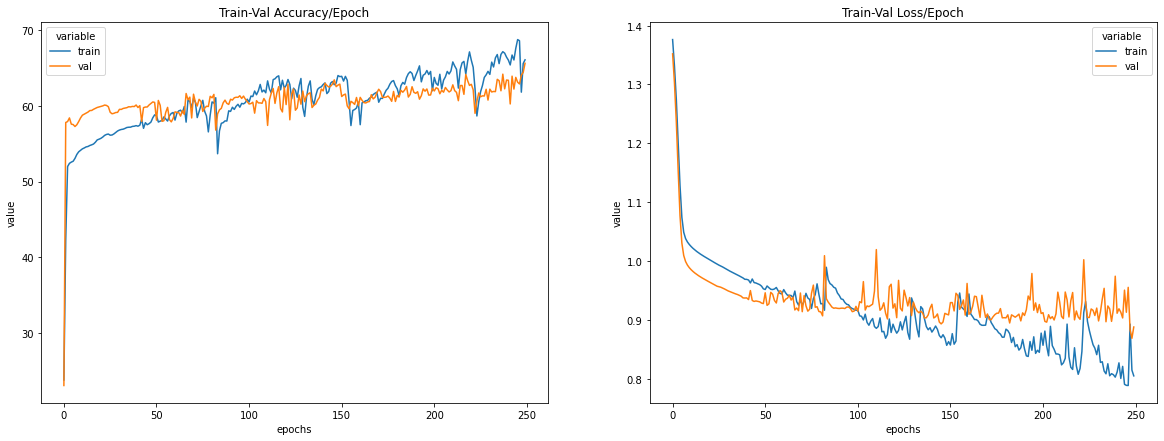

In [33]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_No_action = pd.DataFrame.from_dict(f1_score_No_action).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Prendi = pd.DataFrame.from_dict(f1_score_Prendi).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Rilascia = pd.DataFrame.from_dict(f1_score_Rilascia).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Premi = pd.DataFrame.from_dict(f1_score_Premi).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val F1-Prendi/Epoch')

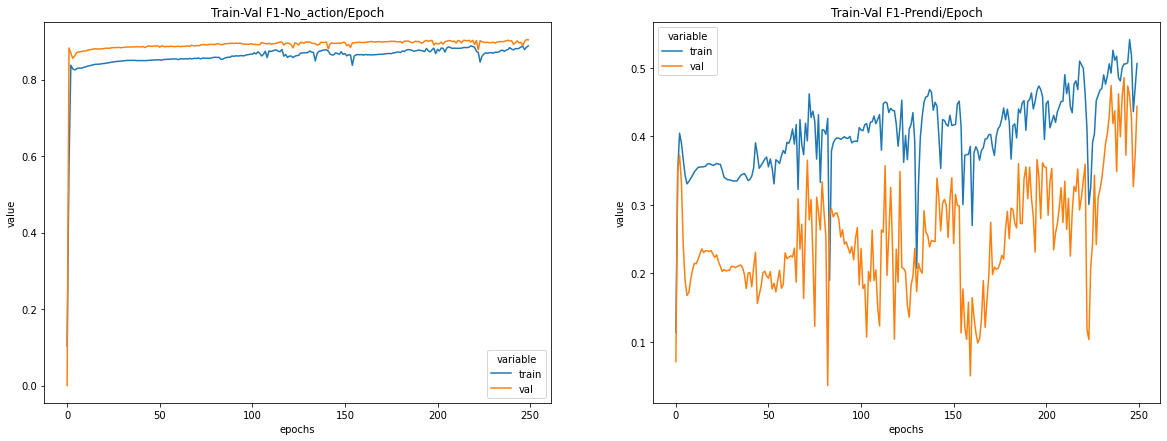

In [34]:
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_f1_No_action, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val F1-No_action/Epoch')
sns.lineplot(data=train_val_f1_Prendi, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val F1-Prendi/Epoch')

Text(0.5, 1.0, 'Train-Val F1-Premi/Epoch')

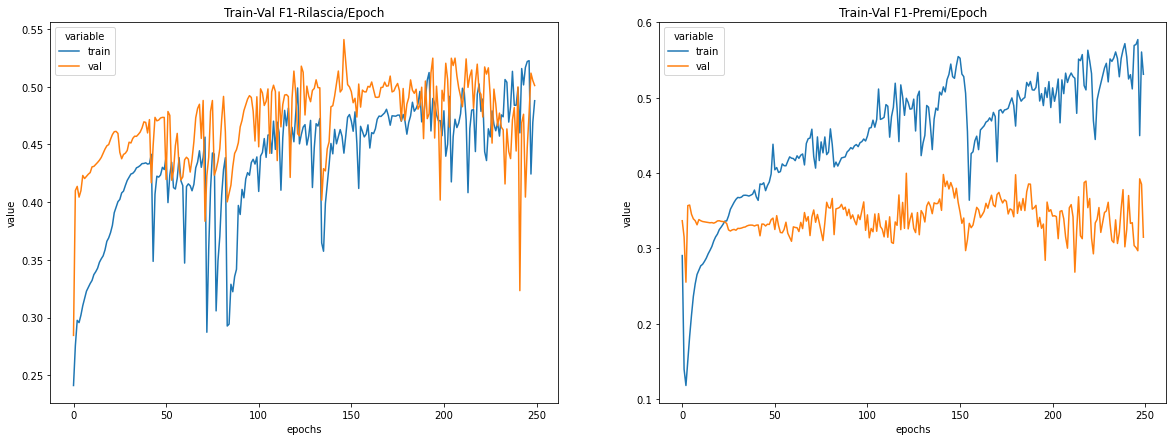

In [35]:
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_f1_Rilascia, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val F1-Rilascia/Epoch')
sns.lineplot(data=train_val_f1_Premi, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val F1-Premi/Epoch')

## Test the model

Al termine dell'addestramento, dobbiamo testare come si è comportato il nostro modello.  Nota che abbiamo usato model.eval() prima di eseguire il nostro codice di test.  Per dire a PyTorch che non vogliamo eseguire la retropropagazione durante l'inferenza, usiamo torch.no_grad(), proprio come abbiamo fatto per il ciclo di convalida sopra.

Iniziamo definendo un elenco che conterrà le nostre previsioni.  Quindi eseguiamo il ciclo dei nostri batch utilizzando test_loader.

In [36]:
y_pred_list = []

with torch.no_grad():

    model.eval()
    for test in test_dataset:
        X_batch = test.X_data.to(device)
        y_test_pred, _ = model(torch.reshape(X_batch, (X_batch.shape[0], 1, X_batch.shape[1])))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
pred_list = []
for pred in y_pred_list:
  for p in pred:
    pred_list.append(p)
print(len(pred_list[:-1]))
print(len(test_Y))

16125
16125


## Confusion Matrix

Creiamo un dataframe dalla matrice di confusione e lo tracciamo come una mappa di calore utilizzando la libreria Seaborn.

<AxesSubplot:>

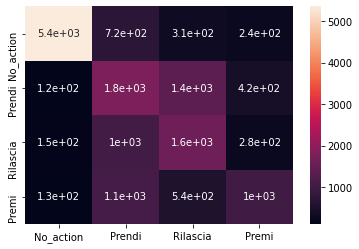

In [37]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_Y, pred_list[:-1])).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [38]:
print(classification_report(test_Y, pred_list[:-1]))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      6633
           1       0.38      0.48      0.43      3685
           2       0.42      0.52      0.47      3066
           3       0.51      0.37      0.43      2741

    accuracy                           0.60     16125
   macro avg       0.56      0.54      0.55     16125
weighted avg       0.64      0.60      0.61     16125



In [41]:
torch.save(model, main_folder + "/model")